In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Flatten, TimeDistributed
import pandas as pd
import math
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from datetime import timedelta
from keras.models import load_model

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(1234)

# Pengumpulan Data 

In [3]:
# Data Bank
file = 'stock_dataset/BBCA.JK.csv'
df = pd.read_csv(file, parse_dates = True,index_col=0)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,2655.0,2655.0,2630.0,2645.0,2403.687744,29302500
2015-01-05,2630.0,2640.0,2625.0,2640.0,2399.144043,25434500
2015-01-06,2600.0,2640.0,2600.0,2620.0,2380.968750,48681500
2015-01-07,2610.0,2640.0,2610.0,2625.0,2385.512695,40334000
2015-01-08,2625.0,2630.0,2595.0,2595.0,2358.249756,54457000
...,...,...,...,...,...,...
2021-12-15,7300.0,7375.0,7275.0,7300.0,7300.000000,52477600
2021-12-16,7375.0,7400.0,7275.0,7275.0,7275.000000,95171400
2021-12-17,7325.0,7500.0,7300.0,7500.0,7500.000000,107096800


In [4]:
# Data Kurs Rupiah
file = 'stock_dataset/Kurs_Transaksi_USD.csv'
df1 = pd.read_csv(file, parse_dates = True,index_col=0)
df1

,Nilai,Kurs Jual,Kurs Beli
Date,,,
2015-01-02,1,12536.00,12412.00
2015-01-05,1,12652.00,12526.00
2015-01-06,1,12721.00,12595.00
2015-01-07,1,12796.00,12668.00
2015-01-08,1,12795.00,12667.00
...,...,...,...
2021-12-15,1,14419.74,14276.26
2021-12-16,1,14408.69,14265.32
2021-12-17,1,14414.72,14271.29


# Preprocessing Data

In [5]:
# menggabungkan data kurs dan data harga saham 
data = pd.merge_asof(df, df1, on='Date')
data = data.rename(columns = {'Adj Close' : 'adj_close', 'Kurs Jual' : 'kurs_jual', 'Kurs Beli' : 'kurs_beli'})
dataset = data.set_index('Date')
dataset

,Open,High,Low,Close,adj_close,Volume,Nilai,kurs_jual,kurs_beli
Date,,,,,,,,,
2015-01-02,2655.0,2655.0,2630.0,2645.0,2403.687744,29302500,1,12536.00,12412.00
2015-01-05,2630.0,2640.0,2625.0,2640.0,2399.144043,25434500,1,12652.00,12526.00
2015-01-06,2600.0,2640.0,2600.0,2620.0,2380.968750,48681500,1,12721.00,12595.00
2015-01-07,2610.0,2640.0,2610.0,2625.0,2385.512695,40334000,1,12796.00,12668.00
2015-01-08,2625.0,2630.0,2595.0,2595.0,2358.249756,54457000,1,12795.00,12667.00
...,...,...,...,...,...,...,...,...,...
2021-12-15,7300.0,7375.0,7275.0,7300.0,7300.000000,52477600,1,14419.74,14276.26
2021-12-16,7375.0,7400.0,7275.0,7275.0,7275.000000,95171400,1,14408.69,14265.32
2021-12-17,7325.0,7500.0,7300.0,7500.0,7500.000000,107096800,1,14414.72,14271.29


In [6]:
# Periksa nilai yang hilang
dataset.isnull().sum()

Open         0
High         0
Low          0
Close        0
adj_close    0
Volume       0
Nilai        0
kurs_jual    0
kurs_beli    0
dtype: int64

In [7]:
#nul_data = pd.isnull(dataset['Close']) 
#dataset[nul_data]

In [8]:
# Ganti nilai yang hilang dengan interpolasi
#dataset = dataset.fillna(dataset.interpolate(method='linear'))
dataset.to_csv("stock_dataset/data_cleaning_bc.csv", index=True)
#dataset.loc[["2019-06-18", "2019-06-19", "2019-06-20"]]
dataset = dataset.reset_index()
dataset

,Date,Open,High,Low,Close,adj_close,Volume,Nilai,kurs_jual,kurs_beli
0,2015-01-02,2655.0,2655.0,2630.0,2645.0,2403.687744,29302500,1,12536.00,12412.00
1,2015-01-05,2630.0,2640.0,2625.0,2640.0,2399.144043,25434500,1,12652.00,12526.00
2,2015-01-06,2600.0,2640.0,2600.0,2620.0,2380.968750,48681500,1,12721.00,12595.00
3,2015-01-07,2610.0,2640.0,2610.0,2625.0,2385.512695,40334000,1,12796.00,12668.00
4,2015-01-08,2625.0,2630.0,2595.0,2595.0,2358.249756,54457000,1,12795.00,12667.00
...,...,...,...,...,...,...,...,...,...,...
1741,2021-12-15,7300.0,7375.0,7275.0,7300.0,7300.000000,52477600,1,14419.74,14276.26
1742,2021-12-16,7375.0,7400.0,7275.0,7275.0,7275.000000,95171400,1,14408.69,14265.32
1743,2021-12-17,7325.0,7500.0,7300.0,7500.0,7500.000000,107096800,1,14414.72,14271.29
1744,2021-12-20,7350.0,7400.0,7325.0,7375.0,7375.000000,74753000,1,14414.72,14271.29


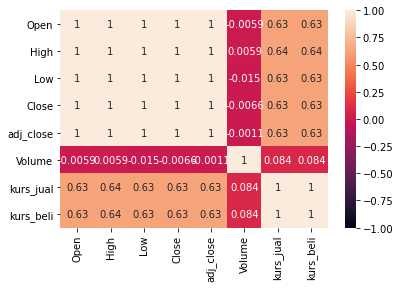

In [9]:
# Korelasi Data
dataset.drop(['Nilai'], axis=1, inplace=True)
matrix = dataset.corr(method='pearson')
ax = sns.heatmap(matrix, vmax=1, vmin=-1, annot=True)
ax.figure.savefig('M:/Metopen/save/korelasi_bca.jpg')

In [10]:
# pemilihan fitur
df = read_csv('stock_dataset/data_cleaning_bc.csv', header=0, index_col=0)
df.drop(['Volume', 'Nilai'], axis=1, inplace=True)
df

,Open,High,Low,Close,adj_close,kurs_jual,kurs_beli
Date,,,,,,,
2015-01-02,2655.0,2655.0,2630.0,2645.0,2403.687744,12536.00,12412.00
2015-01-05,2630.0,2640.0,2625.0,2640.0,2399.144043,12652.00,12526.00
2015-01-06,2600.0,2640.0,2600.0,2620.0,2380.968750,12721.00,12595.00
2015-01-07,2610.0,2640.0,2610.0,2625.0,2385.512695,12796.00,12668.00
2015-01-08,2625.0,2630.0,2595.0,2595.0,2358.249756,12795.00,12667.00
...,...,...,...,...,...,...,...
2021-12-15,7300.0,7375.0,7275.0,7300.0,7300.000000,14419.74,14276.26
2021-12-16,7375.0,7400.0,7275.0,7275.0,7275.000000,14408.69,14265.32
2021-12-17,7325.0,7500.0,7300.0,7500.0,7500.000000,14414.72,14271.29


In [11]:
# pindah kolom baris close ke baris pertama
last_col = df.pop('Close')
type(last_col)
pd.core.series.Series
df.insert(loc=0, column = 'Close', value = last_col)
df

,Close,Open,High,Low,adj_close,kurs_jual,kurs_beli
Date,,,,,,,
2015-01-02,2645.0,2655.0,2655.0,2630.0,2403.687744,12536.00,12412.00
2015-01-05,2640.0,2630.0,2640.0,2625.0,2399.144043,12652.00,12526.00
2015-01-06,2620.0,2600.0,2640.0,2600.0,2380.968750,12721.00,12595.00
2015-01-07,2625.0,2610.0,2640.0,2610.0,2385.512695,12796.00,12668.00
2015-01-08,2595.0,2625.0,2630.0,2595.0,2358.249756,12795.00,12667.00
...,...,...,...,...,...,...,...
2021-12-15,7300.0,7300.0,7375.0,7275.0,7300.000000,14419.74,14276.26
2021-12-16,7275.0,7375.0,7400.0,7275.0,7275.000000,14408.69,14265.32
2021-12-17,7500.0,7325.0,7500.0,7300.0,7500.000000,14414.72,14271.29


In [12]:
# pastikan semua data bertipe float
values = df.values
values = values.astype('float32')
values

# normalisasi fitur
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.07012749, 0.06877831, 0.0516949 , ..., 0.05944788, 0.00694633,
        0.00701714],
       [0.06921676, 0.06425342, 0.04915255, ..., 0.05864465, 0.03380632,
        0.03368187],
       [0.06557375, 0.05882356, 0.04915255, ..., 0.05543157, 0.04978323,
        0.04982114],
       ...,
       [0.95446265, 0.91402715, 0.8728814 , ..., 0.9603865 , 0.4419651 ,
        0.44190812],
       [0.93169403, 0.918552  , 0.85593224, ..., 0.9382888 , 0.4419651 ,
        0.44190812],
       [0.93169403, 0.91402715, 0.85593224, ..., 0.9382888 , 0.45150495,
        0.45144892]], dtype=float32)

In [13]:
# konversi series ke supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
# frame sebagai supervised learning
ref = series_to_supervised(scaled, 1, 1)
ref

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.070127,0.068778,0.051695,0.079630,0.059448,0.006946,0.007017,0.069217,0.064253,0.049153,0.078704,0.058645,0.033806,0.033682
2,0.069217,0.064253,0.049153,0.078704,0.058645,0.033806,0.033682,0.065574,0.058824,0.049153,0.074074,0.055432,0.049783,0.049821
3,0.065574,0.058824,0.049153,0.074074,0.055432,0.049783,0.049821,0.066485,0.060634,0.049153,0.075926,0.056235,0.067150,0.066896
4,0.066485,0.060634,0.049153,0.075926,0.056235,0.067150,0.066896,0.061020,0.063348,0.047458,0.073148,0.051415,0.066918,0.066662
5,0.061020,0.063348,0.047458,0.073148,0.051415,0.066918,0.066662,0.059199,0.059729,0.044915,0.071296,0.049809,0.045615,0.045611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,0.918033,0.909502,0.851695,0.939815,0.925030,0.442662,0.442605,0.918033,0.909502,0.851695,0.939815,0.925030,0.443128,0.443071
1742,0.918033,0.909502,0.851695,0.939815,0.925030,0.443128,0.443071,0.913479,0.923077,0.855932,0.939815,0.920611,0.440569,0.440512
1743,0.913479,0.923077,0.855932,0.939815,0.920611,0.440569,0.440512,0.954463,0.914027,0.872881,0.944444,0.960387,0.441965,0.441908
1744,0.954463,0.914027,0.872881,0.944444,0.960387,0.441965,0.441908,0.931694,0.918552,0.855932,0.949074,0.938289,0.441965,0.441908


In [15]:
# drop kolom yang tidak ingin diprediksi
ref.drop(ref.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
ref.to_csv("stock_dataset/normalisasi_bc.csv", index=False)
ref

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,0.070127,0.068778,0.051695,0.079630,0.059448,0.006946,0.007017,0.069217
2,0.069217,0.064253,0.049153,0.078704,0.058645,0.033806,0.033682,0.065574
3,0.065574,0.058824,0.049153,0.074074,0.055432,0.049783,0.049821,0.066485
4,0.066485,0.060634,0.049153,0.075926,0.056235,0.067150,0.066896,0.061020
5,0.061020,0.063348,0.047458,0.073148,0.051415,0.066918,0.066662,0.059199
...,...,...,...,...,...,...,...,...
1741,0.918033,0.909502,0.851695,0.939815,0.925030,0.442662,0.442605,0.918033
1742,0.918033,0.909502,0.851695,0.939815,0.925030,0.443128,0.443071,0.913479
1743,0.913479,0.923077,0.855932,0.939815,0.920611,0.440569,0.440512,0.954463
1744,0.954463,0.914027,0.872881,0.944444,0.960387,0.441965,0.441908,0.931694


In [16]:
# pembagian data pelatihan, validasi dan pengujian
values = ref.values

train_size = 0.8
valid_size=0.1

train_index = int(len(values)*train_size)

train = values[0:train_index]
rem = values[train_index:]

valid_index = int(len(values)*valid_size)

valid = values[train_index:train_index+valid_index]
test = values[train_index+valid_index:]

print(train.shape, valid.shape, test.shape)

(1396, 8) (174, 8) (175, 8)


In [17]:
# membuat dataset
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
valid_X, valid_y = valid[:, :-1], valid[:, -1]

# reshape masukan menjadi 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)

(1396, 1, 7) (1396,) (174, 1, 7) (174,) (175, 1, 7) (175,)


# Perancangan dan Pelatihan Model biLSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 208)           93184     
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 208)               0         
                                                                 
 dense (Dense)               (None, 95)                19855     
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 96        
                                                                 
Total params: 113,135
Trainable params: 113,135
Non-trainable params: 0
__________________________________________________

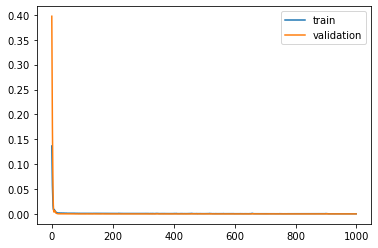

In [18]:
# membuat rancangan model
model = Sequential()
# bidirectinal layer
model.add(Bidirectional(LSTM(104, return_sequences=True),input_shape=(train_X.shape[1], train_X.shape[2])))
# fully connected layer
model.add(Flatten())
model.add(Dense(95, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
opt = tf.keras.optimizers.Adam(0.0005)
model.compile(loss='mse', optimizer= opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()
# pelatihan model
history = model.fit(train_X, train_y, batch_size= 250, epochs= 1000, validation_data=(valid_X, valid_y), verbose=0, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.savefig('M:/Metopen/save/loss_bc.jpg', format='jpg', dpi=1000)
pyplot.legend()
pyplot.show()

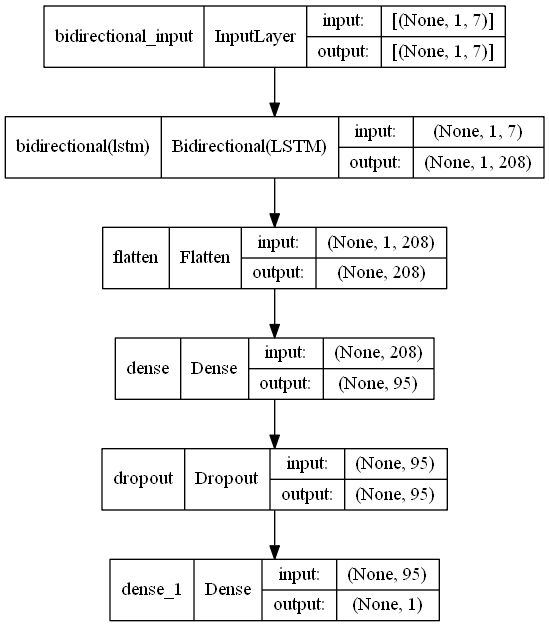

In [19]:
# plot model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model    
plot_model(model, to_file='M:/Metopen/save/model_bc.png', show_shapes=True, show_layer_names=True)

# Evaluasi Model

In [20]:
# evaluasi model dengan data valid
evaluasi = model.evaluate(train_X, train_y)
print("train loss:", "train metrics:", evaluasi)

44/44 [==============================] - 0s 3ms/step - loss: 1.6770e-04 - root_mean_squared_error: 0.0129
train loss: train metrics: [0.00016770172805991024, 0.012949970550835133]


In [21]:
# evaluasi model dengan data pengujian
evaluasi = model.evaluate(test_X, test_y)
print("test loss:", "test metrics:", evaluasi)

6/6 [==============================] - 0s 3ms/step - loss: 2.7461e-04 - root_mean_squared_error: 0.0166
test loss: test metrics: [0.00027460517594590783, 0.01657121442258358]


In [22]:
model.save('M:/Metopen/save/model_bca.h5')
model.save_weights('M:/Metopen/save/model_weights_bca.h5')

# Prediksi Data

In [23]:
# load model
model = load_model('M:/Metopen/save/model_bca.h5')
model.load_weights('M:/Metopen/save/model_weights_bca.h5')


# load data bank BRI baru
df = read_csv('stock_dataset/BBCA.JK_revisi.csv', parse_dates = True, index_col=0)
dataset = df.reset_index()

In [24]:
data = dataset.set_index('Date')
last_col = data.pop('Close')
type(last_col)
pd.core.series.Series
data.insert(loc=0, column = 'Close', value = last_col)
data

,Close,Open,High,Low,Adj Close,Kurs Jual,Kurs Beli
Date,,,,,,,
2021-12-22,7325,7425,7425,7325,7214.434082,14420.75,14277.26
2021-12-23,7300,7325,7350,7300,7189.811523,14335.32,14192.68
2021-12-24,7300,7300,7350,7300,7189.811523,14322.26,14179.75
2021-12-27,7350,7300,7350,7300,7239.056641,14290.10,14147.91
2021-12-28,7350,7375,7400,7325,7239.056641,14296.13,14153.88
...,...,...,...,...,...,...,...
2022-08-24,7950,7950,8025,7900,7950.000000,14956.41,14807.59
2022-08-25,8075,8000,8100,7900,8075.000000,14967.47,14818.53
2022-08-26,8000,8025,8125,8000,8000.000000,14925.25,14776.75


In [25]:
# normalisasi data uji baru
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)

# konversi data uji baru
ref = series_to_supervised(scaled, 1, 1)
ref.drop(ref.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
ref

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,0.270833,0.313725,0.270833,0.302326,0.178695,0.161492,0.161492,0.250000
2,0.250000,0.235294,0.208333,0.279070,0.158176,0.055895,0.055895,0.250000
3,0.250000,0.215686,0.208333,0.279070,0.158176,0.039752,0.039752,0.291667
4,0.291667,0.215686,0.208333,0.279070,0.199214,0.000000,0.000000,0.291667
5,0.291667,0.274510,0.250000,0.302326,0.199214,0.007453,0.007453,0.250000
...,...,...,...,...,...,...,...,...
160,0.750000,0.764706,0.750000,0.837209,0.750000,0.793788,0.793788,0.791667
161,0.791667,0.725490,0.770833,0.837209,0.791667,0.823601,0.823601,0.895833
162,0.895833,0.764706,0.833333,0.837209,0.895833,0.837272,0.837260,0.833333
163,0.833333,0.784314,0.854167,0.930233,0.833333,0.785086,0.785098,0.958333


In [26]:
# membuat dataset 
values = ref.values
new_test_X, new_test_y = values[:, :-1], values[:, -1]
new_test_X = new_test_X.reshape((new_test_X.shape[0], 1, new_test_X.shape[1]))
print(new_test_X.shape, new_test_y.shape)

(164, 1, 7) (164,)


In [27]:
# membuat prediksi dengan data yang baru 
predict = model.predict(new_test_X)
new_test_X = new_test_X.reshape((new_test_X.shape[0], new_test_X.shape[2]))
# denormalisasi untuk data prediksi
inv_predict = concatenate((predict, new_test_X[:, 1:]), axis=1)
inv_predict = scaler.inverse_transform(inv_predict)
inv_predict = inv_predict[:, 0]
# denormalisasi untuk data aktual
new_test_y = new_test_y.reshape((len(new_test_y), 1))
inv_actual = concatenate((new_test_y, new_test_X[:, 1:]), axis=1)
inv_actual = scaler.inverse_transform(inv_actual)
inv_actual = inv_actual[:,0]

In [28]:
# hasil prediksi sebelum denormalisasi
predict

array([[0.26203588],
       [0.23341218],
       [0.23287217],
       [0.26142132],
       [0.27493167],
       [0.23871773],
       [0.23421277],
       [0.25318447],
       [0.30371088],
       [0.34841877],
       [0.37249076],
       [0.4954971 ],
       [0.476462  ],
       [0.5498796 ],
       [0.55606246],
       [0.56136227],
       [0.64851993],
       [0.6131724 ],
       [0.5273907 ],
       [0.5283972 ],
       [0.5961    ],
       [0.7215657 ],
       [0.6516193 ],
       [0.59594184],
       [0.5611105 ],
       [0.61126554],
       [0.61854446],
       [0.5186112 ],
       [0.6225356 ],
       [0.59222233],
       [0.5903994 ],
       [0.62845874],
       [0.6009618 ],
       [0.74498725],
       [0.6290424 ],
       [0.6324208 ],
       [0.5750599 ],
       [0.6811048 ],
       [0.7674548 ],
       [0.7176832 ],
       [0.7450354 ],
       [0.7726078 ],
       [0.73172843],
       [0.8319061 ],
       [0.82194304],
       [0.8511733 ],
       [0.86899805],
       [0.827

In [29]:
# hasil prediksi pada setiap langkah waktu
inv_test_X= scaler.inverse_transform(new_test_X)

for i in range(len(inv_test_X)):
    print("X=%s, Predicted= %s" % (inv_test_X[i], inv_predict[i]))

X=[ 7325.        7425.        7425.        7325.        7214.434082
 14420.75     14277.26    ], Predicted= 7314.443051815033
X=[ 7300.        7325.        7350.        7300.        7189.811523
 14335.32     14192.68    ], Predicted= 7280.094611644745
X=[ 7300.        7300.        7350.        7300.        7189.811523
 14322.26     14179.75    ], Predicted= 7279.44660782814
X=[ 7350.        7300.        7350.        7300.        7239.056641
 14290.1      14147.91    ], Predicted= 7313.705587387085
X=[ 7350.        7375.        7400.        7325.        7239.056641
 14296.13     14153.88    ], Predicted= 7329.918003082275
X=[ 7300.        7350.        7375.        7300.        7189.811523
 14308.19     14165.82    ], Predicted= 7286.461281776428
X=[ 7300.        7350.        7350.        7300.        7189.811523
 14336.33     14193.68    ], Predicted= 7281.055325269699
X=[ 7325.        7325.        7400.        7300.        7214.434082
 14340.35     14197.66    ], Predicted= 7303.821361

In [30]:
# menghitung nilai RMSE dan Mape pada hasil prediksi
rmse = sqrt(mean_squared_error(inv_predict, inv_actual))
print('Test RMSE: %.2f' % rmse)
mape = np.mean(np.abs((inv_actual - inv_predict)/inv_actual))*100
print(f'Test MAPE: {np.round(mape, 2)} %')

Test RMSE: 114.00
Test MAPE: 1.1 %


In [31]:
# insert nilai tanggal, aktual, prediksi
test = dataset.drop(dataset.index[0])
test.insert(1, "Prediction", inv_predict.ravel(), True)
#test.insert(1, "Difference", test["Prediction"] - test["Actual"], True)

In [32]:
# perbandingan hasil pengujian dan prediksi
test = pd.DataFrame(test, columns = ["Date", "Close", "Prediction"])
test["RMSE"] = test.apply(lambda x: mean_squared_error(test.loc[:x.name, 'Close'].tolist(), test.loc[:x.name, 'Prediction'].tolist(), squared=False), axis = 1)
test["MAPE"] = test.apply(lambda x: np.mean(np.abs((test.loc[:x.name, 'Close'].tolist() - test.loc[:x.name, 'Prediction'])/test.loc[:x.name, 'Close'].tolist()))*100, axis=1)
test.to_csv("M:/Metopen/save/hasil_prediksi_bc.csv", index=False)
print(test)

          Date  Close   Prediction        RMSE      MAPE
1   2021-12-23   7300  7314.443052   14.443052  0.197850
2   2021-12-24   7300  7280.094612   17.390029  0.235263
3   2021-12-27   7350  7279.446608   43.137792  0.476812
4   2021-12-28   7350  7313.705587   41.532794  0.481060
5   2021-12-29   7300  7329.918003   39.484120  0.466815
..         ...    ...          ...         ...       ...
160 2022-08-24   7950  7926.332855  114.536312  1.105864
161 2022-08-25   8075  7961.240625  114.531503  1.107746
162 2022-08-26   8000  8048.730993  114.241638  1.104668
163 2022-08-29   8150  8033.202362  114.257493  1.106683
164 2022-08-30   8175  8117.415285  113.997333  1.104230

[164 rows x 5 columns]


# Visualisasi Data

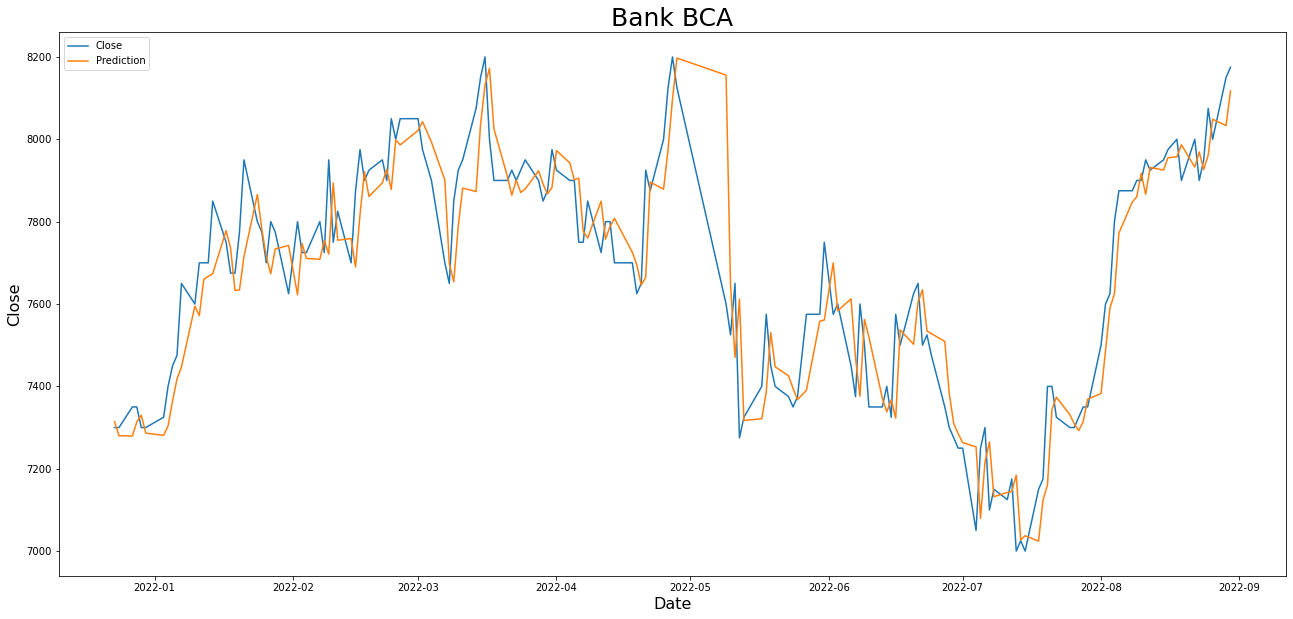

In [33]:
# visualisasi data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = test["Date"]
yt = test[["Close", "Prediction"]]
plt.title("Bank BCA", fontsize= 25)
plt.plot(xt, yt["Close"])
plt.ylabel("Close", fontsize= 16)
plt.xlabel("Date", fontsize= 16)
plt.plot(xt, yt["Prediction"])
plt.legend(["Close","Prediction"], loc="upper left")
plt.savefig('M:/Metopen/save/hasil_prediksi_bc.jpg', format='jpg', dpi=1000)

#plt.grid()
plt.show()